# Web-Scraping-Job-From-Indeed
Web scraping job from Indeed using Beautifulsoup and checking top words and specific skills according to the description of the job.

In [1]:
# importing the libraries
import requests
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from operator import itemgetter
from datetime import datetime

### Let´s request access to the Indeed website, looking for Data Analyst

In [2]:
def request_URL(URL):
    #show the website
    #print(URL)
    
    #conducting a request of the stated URL above:
    page = requests.get(URL)

    #specifying a desired format of 'page' using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

In [3]:
# we will search for job that contain the word bellow as example
word = 'data+analyst'
URL = 'https://ie.indeed.com/jobs?as_and=' + word + '&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=100&l=Dublin&fromage=any&limit=1000&sort=date&psf=advsrch&from=advancedsearch'
soup = request_URL(URL)

### Let´s get the identification of each job to check the full description of the job

In [4]:
# get the identification of each job
keys = [div.get('data-jk') for div in soup.findAll('div', attrs={'data-tn-component': 'organicJob'})]

### Let´s request the access of each specific information

In [5]:
# For each specific job(key) get the request
job_information = []
for job in keys:
    URL_job = 'https://ie.indeed.com/viewjob?jk=' + job
    soup_job = request_URL(URL_job)
   
    company = soup_job.find(name='div', attrs={'class':'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).get_text()
    title = soup_job.find(name='h1', attrs={'class':'icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title'}).get_text()
    job_description = soup_job.find('div', attrs={'id': 'jobDescriptionText'}).get_text()
    date = datetime.now()    
    
    job_information.append((date, company, title, job_description, URL_job))

In [6]:
# using set_option to show all text - not truncated
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(job_information,columns=['date','company','title','full description', 'link'])

### Let´s create a file with the information about the jobs selected

In [7]:
file_name = 'Files/jobs_indeed_' + word + '.csv'
df.to_csv(file_name, mode='a', encoding='utf-8')

### Now we need to clean up the text to get rid of space, blank lines, punctuation...

In [8]:
# cleaning using regex
def clean_text(text):
    text = re.sub(r'[\n]',' ',text) # delete \n
    text = re.sub('\s+',' ',text) # delete spaces
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text) # delete all punctuation
    text = re.sub('—','',text)
    text = re.sub('’s','',text)
    text = re.sub('Â·','',text)
    text = re.sub('â€“','',text)
    text = re.sub('â€™','',text)
    text = re.sub('. . .','',text)
    text = re.sub('##','',text)
    return text

# cleaning the column summary using regex
df['full description'] = df['full description'].apply(lambda x: clean_text(x))

In [9]:
# let´s check how many company
total_comp =len(df['company'])
print(total_comp)

48


### Now we will check the frequency of the words and eliminate the irrelevant words(stopwords)

In [10]:
blob = TextBlob(str(df['full description']))

# word_counts is a dictionary, so we use items and get rid off the stop words
items = blob.word_counts.items() 

stop_words = stopwords.words('english')
items = [item for item in items if item[0] not in stop_words]

# now we will create a df with the frequency of the words
df_word_count = pd.DataFrame(items, columns=['word','count'])
df_word_count.sort_values(by='count',ascending=False,inplace=True)

### Visualization of the Top words 

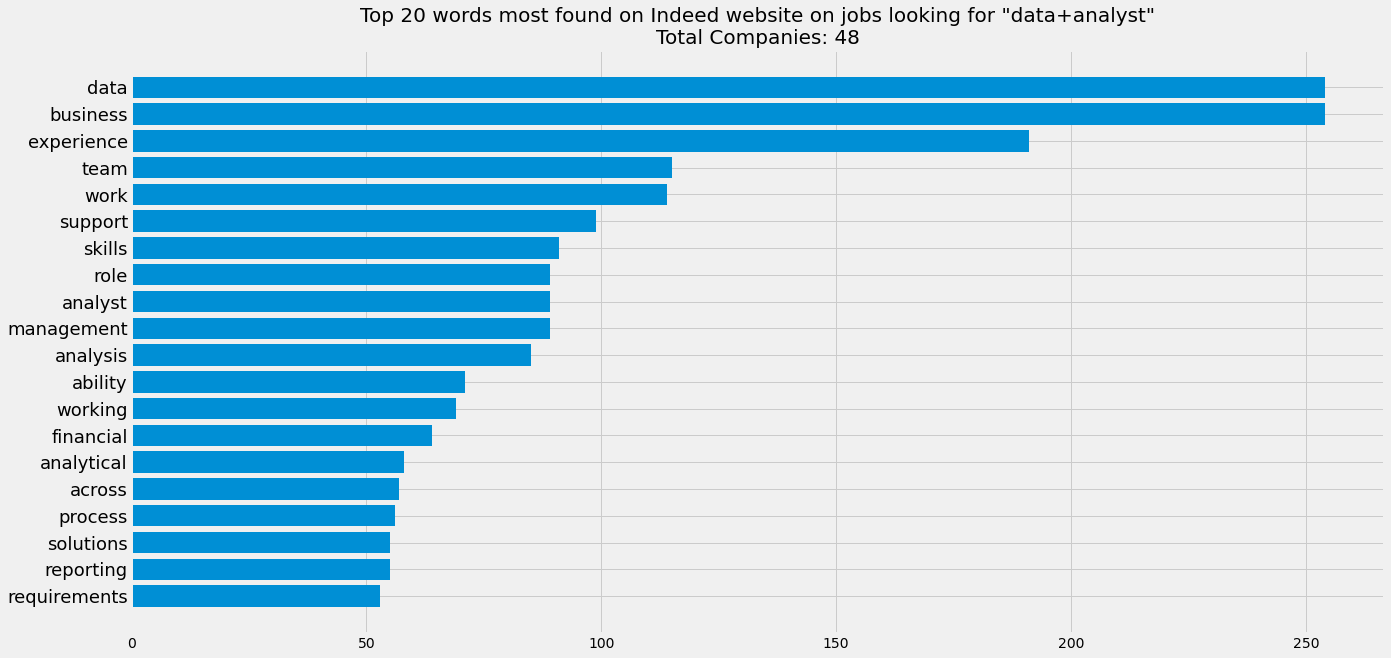

In [11]:
# plot the top20 words
df_top = df_word_count.head(20)

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title(f'Top 20 words most found on Indeed website on jobs looking for "{word}"\nTotal Companies: {total_comp}',fontsize=20)
plt.barh(df_top['word'],df_top['count'])
plt.yticks(fontsize=18)
plt.gca().invert_yaxis()
plt.show()

### Let´s check some skills that the companies are looking for

In [12]:
skills = ['python','sql','nosql','tableau', 'excel', 'aws','git','scrum','agile','statistics','reports','azure','cloud','lifecycle','etl','vba']

list_skills = []
for s in skills:
    list_skills.append((s,'/'.join(df['company'][df['full description'].str.lower().str.contains(s)])))
    
df_skill = pd.DataFrame(list_skills, columns=['skill','companies'])

# insert a column with the total of companies looking for the skill
df_skill['total'] = df_skill['companies'].str.count('/')
df_skill.sort_values(by='total',ascending=False,inplace=True)
df_skill

,skill,companies,total
4,excel,"DHL Express/PokerStars/Aptiv/eDesk/Adobe/Computer Futures/Intercontinental Exchange/eShopWorld/PokerStars/HubSpot/Principle HR/Morgan McKinley/Recruiters/Sigmar Recruitment/realTime/Sigmar Recruitment/IBPM Ireland/LSEG (London Stock Exchange Group)/Leveris Limited/Ervia/Barclay Simpson, EA Licence No: 11S4540/Principle HR/Brown Thomas Group/Mackin/Principle/Amazon EU SARL/Morgan McKinley/Morgan McKinley/Sigmar Recruitment/Fenergo/Ryanair/Guidewire Software, Inc./Reperio Human Capital/eShopWorld/Marsh and McLennan/Sogeti Ireland",35
1,sql,"PokerStars/AMZN Pymnts Europe S.C.A.(LUX)/eDesk/Adobe/Allen Recruitment Consulting/eShopWorld/PokerStars/HubSpot/Principle HR/Eolas Recruitment/Recruiters/Principle HR/Arch Europe Insurance Services Ltd/Brown Thomas Group/Mackin/Codec/Principle/Amazon EU SARL/Morgan McKinley/Morgan McKinley/Guidewire Software, Inc./Reperio Human Capital/eShopWorld/Sogeti Ireland",23
10,reports,PokerStars/AMZN Pymnts Europe S.C.A.(LUX)/eDesk/Adobe/Intercontinental Exchange/PokerStars/LSEG (London Stock Exchange Group)/Ardagh Group/Arch Europe Insurance Services Ltd/Amazon EU SARL/Fenergo/Ryanair/eShopWorld/Morgan McKinley,13
3,tableau,eDesk/Adobe/Allen Recruitment Consulting/PokerStars/Principle HR/Recruiters/Principle HR/Mackin/Principle/Amazon EU SARL/Morgan McKinley/Morgan McKinley/Reperio Human Capital,12
6,git,"PokerStars/eDesk/Adobe/PokerStars/HubSpot/Ardagh Group/Ryanair/Guidewire Software, Inc.",7
8,agile,eShopWorld/The Coca-Cola Company/Morgan McKinley/Eolas Recruitment/Brown Thomas Group/Ryanair/The Coca-Cola Company/Sogeti Ireland,7
9,statistics,AMZN Pymnts Europe S.C.A.(LUX)/The Coca-Cola Company/IBPM Ireland/Mackin/Amazon EU SARL/Morgan McKinley/Allianz SE Reinsurance,6
12,cloud,The Coca-Cola Company/Morgan McKinley/Brown Thomas Group/Codec/Fenergo,4
13,lifecycle,Aptiv/Morgan McKinley/LSC/LSEG (London Stock Exchange Group)/Ardagh Group,4
5,aws,"The Coca-Cola Company/LSEG (London Stock Exchange Group)/Guidewire Software, Inc./The Coca-Cola Company",3


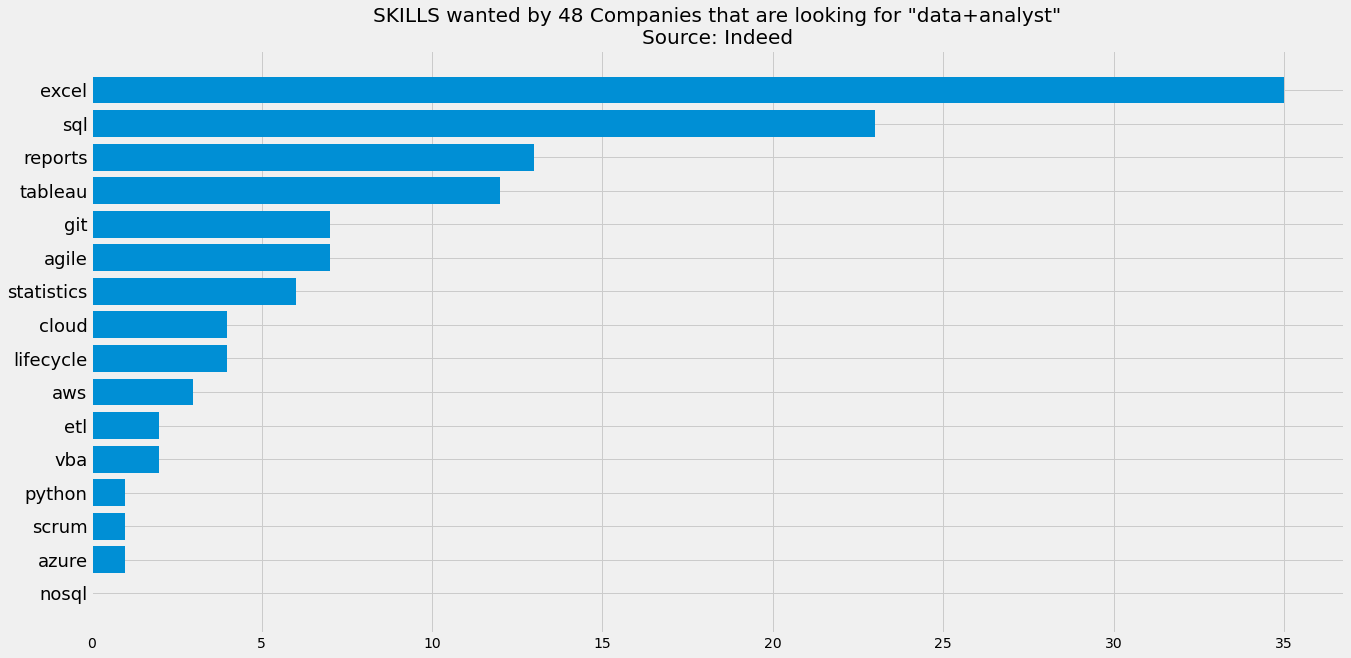

In [13]:
# plot the skills per company

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
plt.title(f'SKILLS wanted by {total_comp} Companies that are looking for "{word}"\nSource: Indeed',fontsize=20)
plt.barh(df_skill['skill'],df_skill['total'])
plt.yticks(fontsize=18)
plt.gca().invert_yaxis()
plt.show()

### Conclusion:
Observing the plots above we can see that the companies looking for Data Analyst on Indeed website, 
Excel and SQL are the most wanted technical skill and
Data, business and experience are the most wanted soft skill